In [92]:
from sklearn import cluster
from nltk.corpus import stopwords
from re import sub
# from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import nltk
import pandas as pd
import numpy as np
import argparse
import itertools
import pickle

from scipy.stats import gaussian_kde


In [300]:
df = pd.read_pickle("clusterLabelData.2023-06-07.pickle")
topics = pd.read_pickle("topic_labels.pickle")

df['cleaned.len'] = df['cleaned'].apply(str.split, sep = " ").apply(len)-1
df['minClean.len'] = df['minClean'].apply(str.split, sep = " ").apply(len)-1
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['topics.bert.8'] = list(topics['bert_topic_label'])
df['topics.fast.8'] = list(topics['fast_topic_label'])
df['ordinalTime'] = [x.toordinal() for x in df['datetime']]


In [95]:
df.columns

Index(['id', 'datetime', 'publisher', 'content', 'cleaned', 'minClean',
       'finalReduc', 'kmeans.fast.8', 'kmeans.bert.10', 'kmeans.tfidf.30',
       'cleaned.len', 'minClean.len', 'year', 'ordinalTime'],
      dtype='object')

Plotting functions

In [287]:
def plotPublisher(column, n):
    publisher = np.unique(df[df[column]==n]['publisher'])
    data = {
        'publisher': publisher,
        'count': [sum(df[df[column]==n]['publisher']==i) for i in publisher]
    }
    plotdf = pd.DataFrame(data)
    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(plotdf['publisher'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:16])
    ax.set_xticks(np.arange(16))
    plt.xticks(rotation=90)
    #ax.set_xticklabels(, rotation=90)
    # Set the labels and title
    ax.set_xlabel('publisher')
    ax.set_ylabel('count')
    ax.set_title('Count of Tweets by Publisher for '+column+' '+str(n))
    # Display the plot
    plt.show()

In [155]:
def plotLength(column, n):
    # plot length
    if 'bert' in column:
        lenCol = 'minClean.len'
    else:
        lenCol = 'cleaned.len'
    length = np.unique(df[df[column]==n][lenCol])
    data = {
        'length': length,
        'count': [sum(df[df[column]==n][lenCol]==i) for i in length]
    }
    plotdf = pd.DataFrame(data)
    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(plotdf['length'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:16])
    ax.set_xticks(np.arange(len(length)))
    ax.set_xticklabels(plotdf['length'], rotation=90)
    # Set the labels and title
    ax.set_xlabel('length')
    ax.set_ylabel('count')
    ax.set_title('Count of Tweets by Length for '+column+' '+str(n))
    # Display the plot
    plt.show()

In [172]:
def plotTime(column, n):
    # plot non-parametric kde on numeric datenum
    timeData = df[df[column]==n]
    ax = timeData['ordinalTime'].plot(kind='kde')
    # rename the xticks with labels
    x_ticks = ax.get_xticks()
    ax.set_xticks(x_ticks[::2])
    xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('time')
    ax.set_ylabel('count')
    ax.set_title('Density of Tweets over Time for '+column+' '+str(n))

In [274]:
def plotKBert(column, n):
    # plot publishers
    clusters = np.unique(df[df[column]==n]['kmeans.bert.10'])
    data = {
        'clusters': clusters,
        'count': [sum(df[df[column]==n]['kmeans.bert.10']==i) for i in clusters]
    }
    plotdf = pd.DataFrame(data)
    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(plotdf['clusters'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:16])
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(range(10), rotation=90)
    # Set the labels and title
    ax.set_xlabel('cluster')
    ax.set_ylabel('count')
    ax.set_title('Count of Tweets by Kmeans.Bert Cluster for '+column+' '+str(n))
    # Display the plot
    plt.show()

In [275]:
def plotKFast(column, n):
    # plot publishers
    clusters = np.unique(df[df[column]==n]['kmeans.fast.8'])
    data = {
        'clusters': clusters,
        'count': [sum(df[df[column]==n]['kmeans.fast.8']==i) for i in clusters]
    }
    plotdf = pd.DataFrame(data)
    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(plotdf['clusters'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:16])
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(range(8), rotation=90)
    # Set the labels and title
    ax.set_xlabel('cluster')
    ax.set_ylabel('count')
    ax.set_title('Count of Tweets by Kmeans.FastText Cluster for '+column+' '+str(n))
    # Display the plot
    plt.show()

In [276]:
def plotKTfidf(column, n):
    # plot publishers
    clusters = np.unique(df[df[column]==n]['kmeans.tfidf.30'])
    data = {
        'clusters': clusters,
        'count': [sum(df[df[column]==n]['kmeans.tfidf.30']==i) for i in clusters]
    }
    plotdf = pd.DataFrame(data)
    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(plotdf['clusters'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:16])
    ax.set_xticks(np.arange(30))
    ax.set_xticklabels(range(30), rotation=90)
    # Set the labels and title
    ax.set_xlabel('cluster')
    ax.set_ylabel('count')
    ax.set_title('Count of Tweets by Kmeans.TF-IDF Cluster for '+column+' '+str(n))
    # Display the plot
    plt.show()

In [290]:
def plotTopicsBert(column, n):
    # plot publishers
    topics = np.unique(df[df[column]==n]['topics.bert.8'])
    data = {
        'topics': topics,
        'count': [sum(df[df[column]==n]['topics.bert.8']==i) for i in topics]
    }
    plotdf = pd.DataFrame(data)
    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(plotdf['topics'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:16])
    ax.set_xticks(np.arange(8))
    plt.xticks(rotation=90)
    # ax.set_xticklabels(rotation=90)
    # Set the labels and title
    ax.set_xlabel('cluster')
    ax.set_ylabel('count')
    ax.set_title('Count of Tweets by Bert Topic Cluster for '+column+' '+str(n))
    # Display the plot
    plt.show()

In [291]:
def plotTopicsFast(column, n):
    # plot publishers
    topics = np.unique(df[df[column]==n]['topics.fast.8'])
    data = {
        'topics': topics,
        'count': [sum(df[df[column]==n]['topics.fast.8']==i) for i in topics]
    }
    plotdf = pd.DataFrame(data)
    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(plotdf['topics'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:16])
    ax.set_xticks(np.arange(8))
    plt.xticks(rotation=90)
    # ax.set_xticklabels(rotation=90)
    # Set the labels and title
    ax.set_xlabel('cluster')
    ax.set_ylabel('count')
    ax.set_title('Count of Tweets by FastText Topic Cluster for '+column+' '+str(n))
    # Display the plot
    plt.show()

In [292]:
def plotTopicsTfidf(column, n):
    # plot publishers
    topics = np.unique(df[df[column]==n]['topics.tfidf.8'])
    data = {
        'topics': topics,
        'count': [sum(df[df[column]==n]['topics.tfidf.8']==i) for i in topics]
    }
    plotdf = pd.DataFrame(data)
    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(plotdf['topics'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:16])
    ax.set_xticks(np.arange(8))
    plt.xticks(rotation=90)
    # ax.set_xticklabels(rotation=90)
    # Set the labels and title
    ax.set_xlabel('cluster')
    ax.set_ylabel('count')
    ax.set_title('Count of Tweets by TF-IDF Topic Cluster for '+column+' '+str(n))
    # Display the plot
    plt.show()

In [302]:
def plotAll(column, n):
    plotLength(column,n)
    plotPublisher(column,n)
    plotTime(column, n)
    plotKBert(column, n)
    plotKFast(column, n)
    plotKTfidf(column, n)
    plotTopicsBert(column,n)
    plotTopicsFast(column,n)

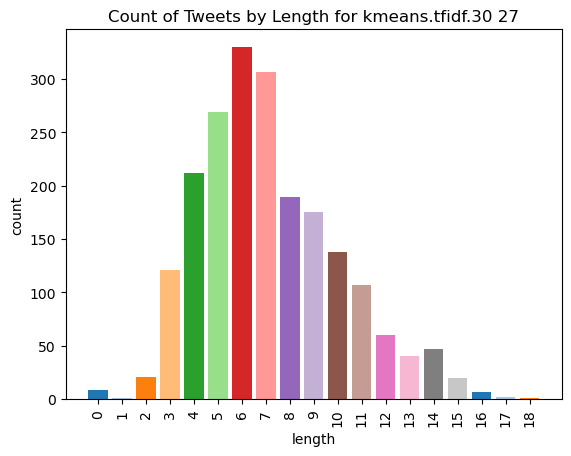

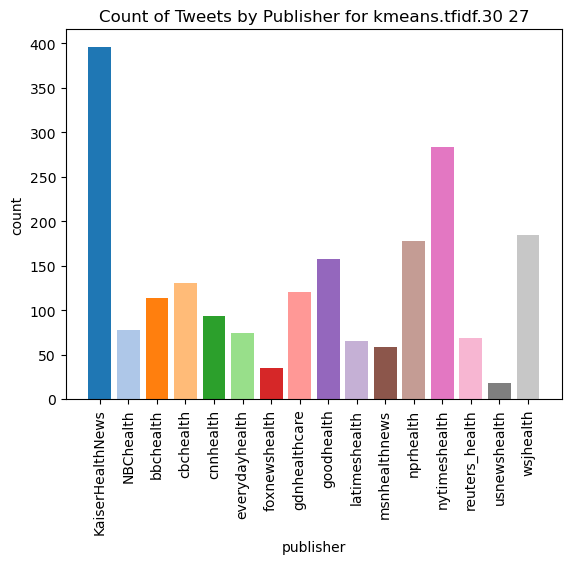

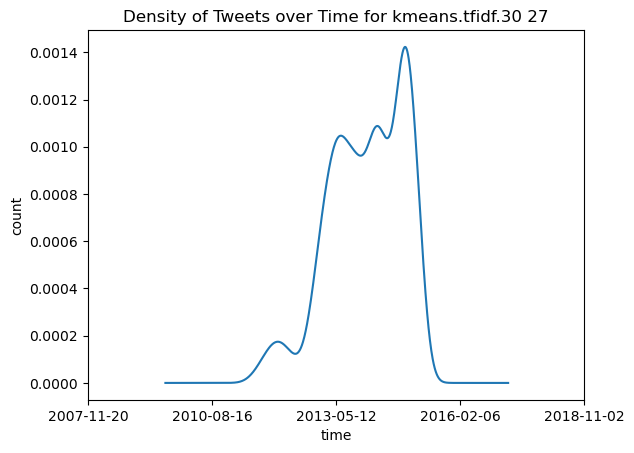

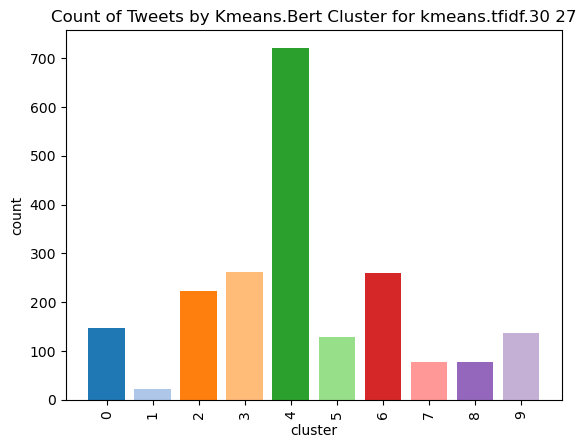

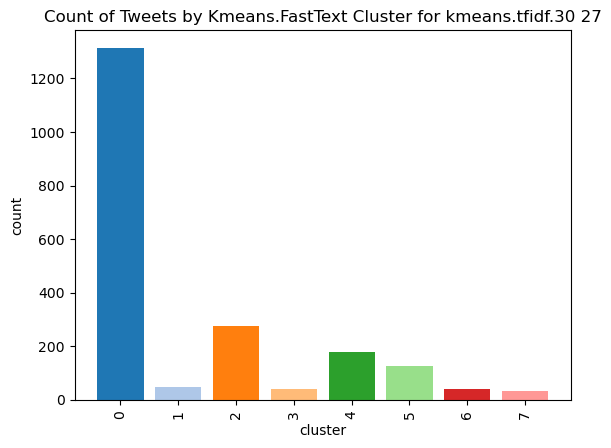

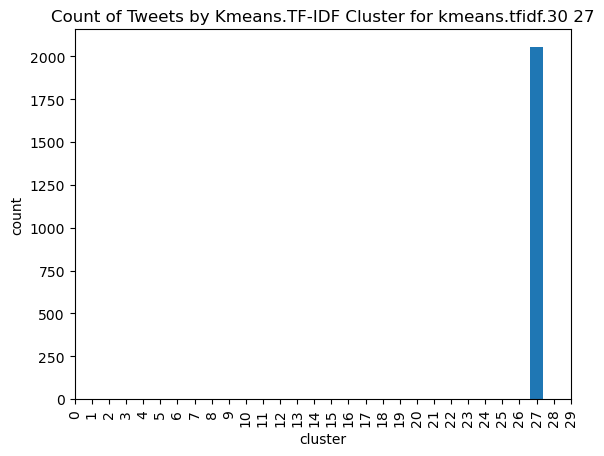

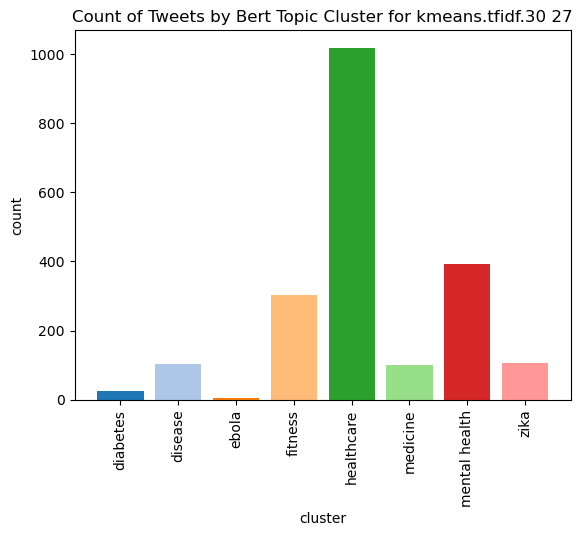

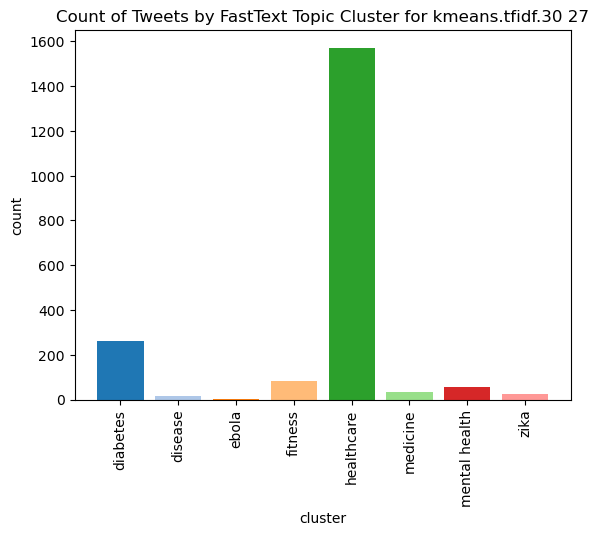

In [303]:
plotAll('kmeans.tfidf.30',27)

Plots for full data

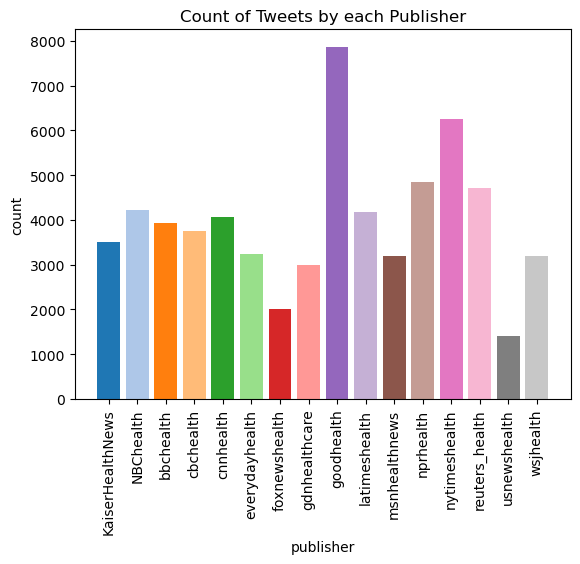

<Figure size 640x480 with 0 Axes>

In [9]:
# Example data

publishers = np.unique(df['publisher'])
data = {
    'publisher': publishers,
    'count': [df[df['publisher']== i].shape[0] for i in publishers]
}
plotdf = pd.DataFrame(data)

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(plotdf['publisher'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:16])
ax.set_xticks(np.arange(16))
ax.set_xticklabels(plotdf['publisher'], rotation=90)

# Set the labels and title
ax.set_xlabel('publisher')
ax.set_ylabel('count')
ax.set_title('Count of Tweets by each Publisher')

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/publisher.counts.2023-06-07.png')

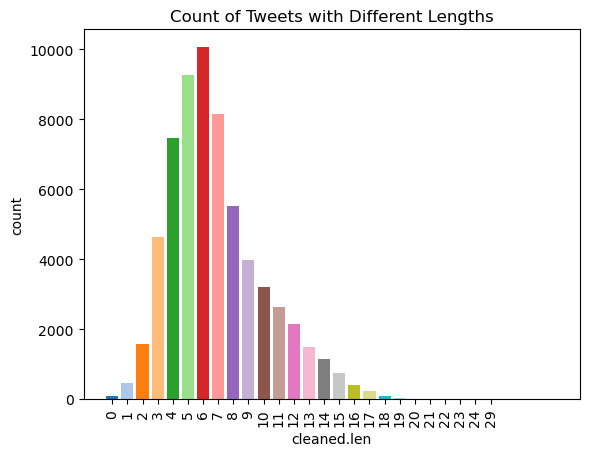

In [264]:
# Example data

length = np.unique(df['cleaned.len'])
data = {
    'cleaned.len': length,
    'count': [df[df['cleaned.len']== i].shape[0] for i in length]
}
plotdf = pd.DataFrame(data)

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(plotdf['cleaned.len'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:30])
ax.set_xticks(np.arange(26))
ax.set_xticklabels(plotdf['cleaned.len'], rotation=90)

# Set the labels and title
ax.set_xlabel('cleaned.len')
ax.set_ylabel('count')
ax.set_title('Count of Tweets with Different Lengths')

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/tweet.length.counts.2023-06-07.png')

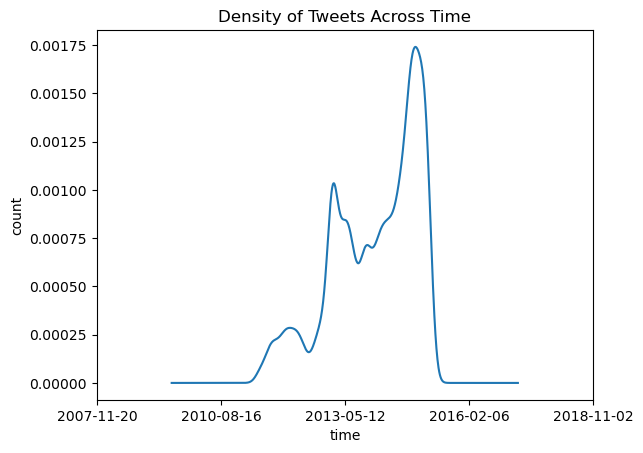

In [265]:
# plot non-parametric kde on numeric datenum
ax = df['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

# Set the labels and title
ax.set_xlabel('time')
ax.set_ylabel('count')
ax.set_title('Density of Tweets Across Time')

# Display the plot
plt.show()

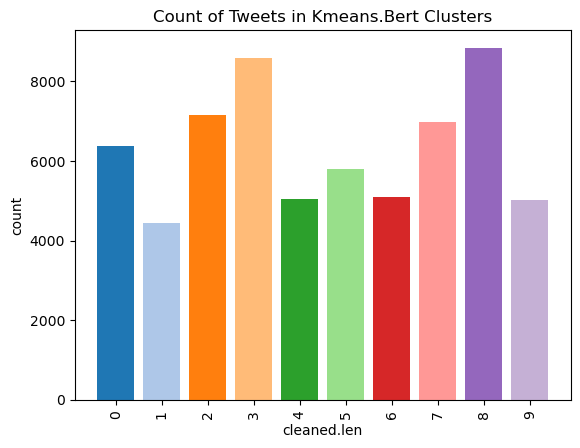

In [267]:
clusters = np.unique(df['kmeans.bert.10'])
data = {
    'clusters': clusters,
    'count': [df[df['kmeans.bert.10']== i].shape[0] for i in clusters]
}
plotdf = pd.DataFrame(data)

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(plotdf['clusters'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:30])
ax.set_xticks(np.arange(10))
ax.set_xticklabels(plotdf['clusters'], rotation=90)

# Set the labels and title
ax.set_xlabel('cleaned.len')
ax.set_ylabel('count')
ax.set_title('Count of Tweets in Kmeans.Bert Clusters')

# Display the plot
plt.show()

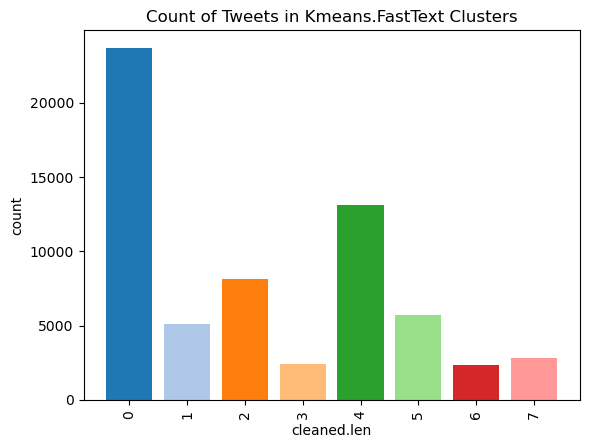

In [268]:
clusters = np.unique(df['kmeans.fast.8'])
data = {
    'clusters': clusters,
    'count': [df[df['kmeans.fast.8']== i].shape[0] for i in clusters]
}
plotdf = pd.DataFrame(data)

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(plotdf['clusters'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:30])
ax.set_xticks(np.arange(8))
ax.set_xticklabels(plotdf['clusters'], rotation=90)

# Set the labels and title
ax.set_xlabel('cleaned.len')
ax.set_ylabel('count')
ax.set_title('Count of Tweets in Kmeans.FastText Clusters')

# Display the plot
plt.show()

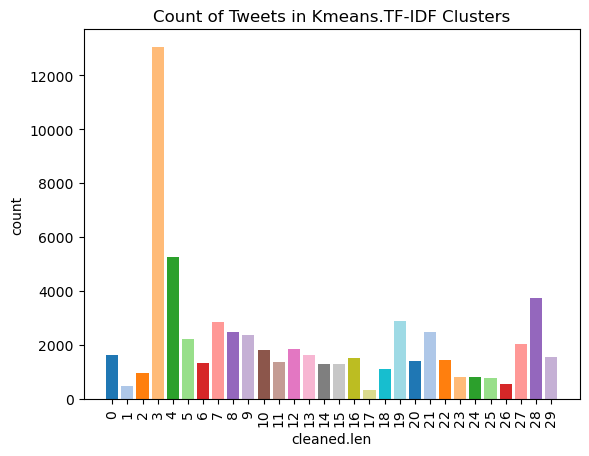

In [269]:
clusters = np.unique(df['kmeans.tfidf.30'])
data = {
    'clusters': clusters,
    'count': [df[df['kmeans.tfidf.30']== i].shape[0] for i in clusters]
}
plotdf = pd.DataFrame(data)

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(plotdf['clusters'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:30])
ax.set_xticks(np.arange(30))
ax.set_xticklabels(plotdf['clusters'], rotation=90)

# Set the labels and title
ax.set_xlabel('cleaned.len')
ax.set_ylabel('count')
ax.set_title('Count of Tweets in Kmeans.TF-IDF Clusters')

# Display the plot
plt.show()

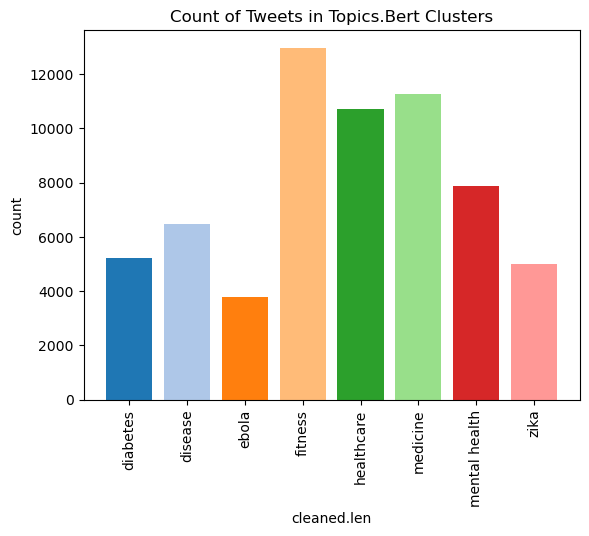

In [271]:
clusters = np.unique(df['topics.bert.8'])
data = {
    'clusters': clusters,
    'count': [df[df['topics.bert.8']== i].shape[0] for i in clusters]
}
plotdf = pd.DataFrame(data)

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(plotdf['clusters'], plotdf['count'], color = plt.cm.tab20(np.linspace(0, 1, 20))[:30])
ax.set_xticks(np.arange(8))
ax.set_xticklabels(plotdf['clusters'], rotation=90)

# Set the labels and title
ax.set_xlabel('cleaned.len')
ax.set_ylabel('count')
ax.set_title('Count of Tweets in Topics.Bert Clusters')

# Display the plot
plt.show()

Old Shit

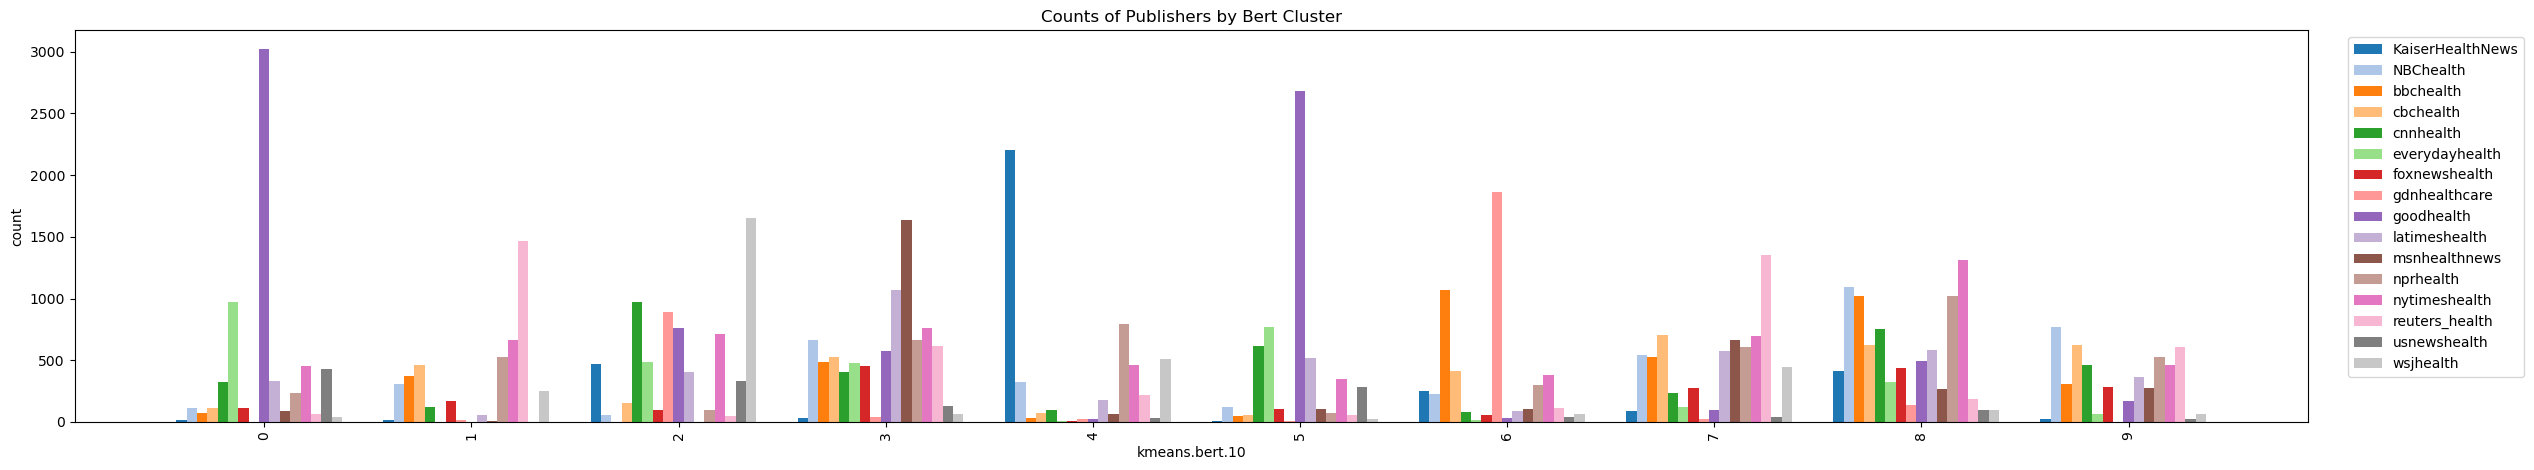

<Figure size 640x480 with 0 Axes>

In [10]:
# Example DataFrame
data = {
    'kmeans.bert.10': df['kmeans.bert.10'],
    'publisher': df['publisher'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['publisher', 'kmeans.bert.10'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:16])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        grouped_data.loc[group],
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('kmeans.bert.10')
ax.set_ylabel('count')
ax.set_title('Counts of Publishers by Bert Cluster')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/pub.by.cluster.bert.2023-06-07.png')

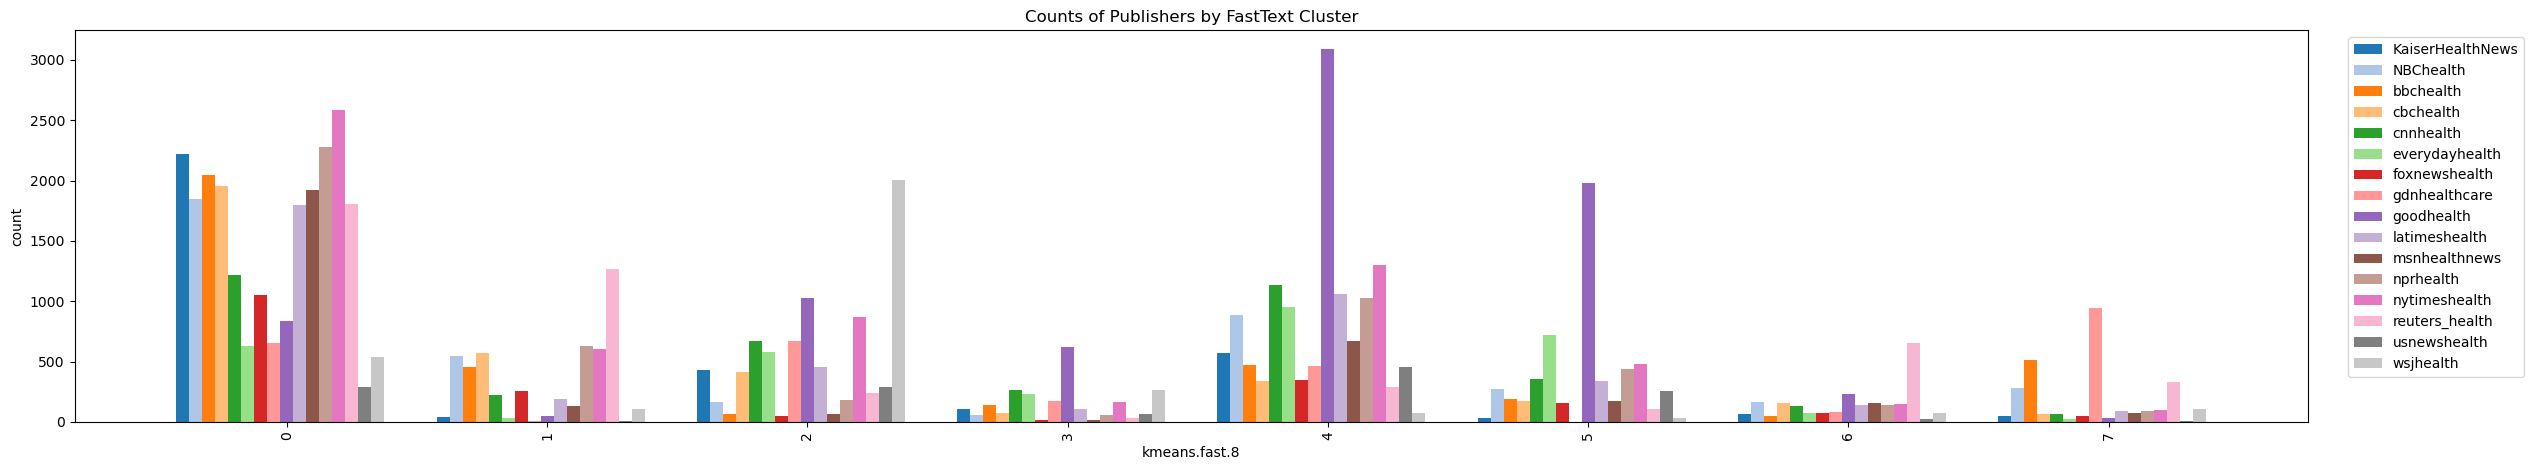

<Figure size 640x480 with 0 Axes>

In [11]:
# Example DataFrame
data = {
    'kmeans.fast.8': df['kmeans.fast.8'],
    'publisher': df['publisher'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['publisher', 'kmeans.fast.8'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:16])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        grouped_data.loc[group],
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('kmeans.fast.8')
ax.set_ylabel('count')
ax.set_title('Counts of Publishers by FastText Cluster')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/pub.by.cluster.fast.2023-06-07.png')

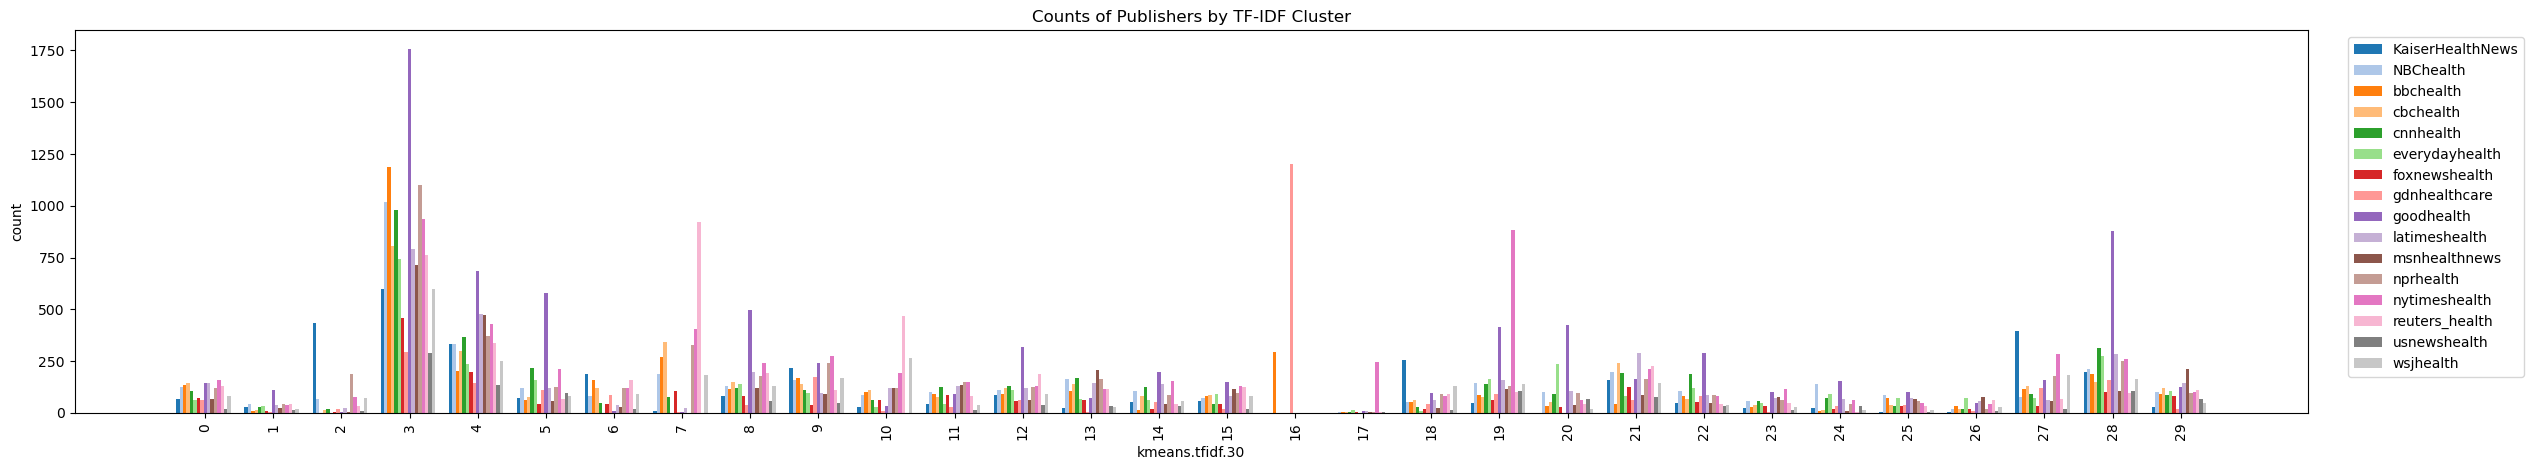

<Figure size 640x480 with 0 Axes>

In [12]:
# Example DataFrame
data = {
    'kmeans.tfidf.30': df['kmeans.tfidf.30'],
    'publisher': df['publisher'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['publisher', 'kmeans.tfidf.30'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:16])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        grouped_data.loc[group],
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('kmeans.tfidf.30')
ax.set_ylabel('count')
ax.set_title('Counts of Publishers by TF-IDF Cluster')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/pub.by.cluster.tfidf.2023-06-07.png')

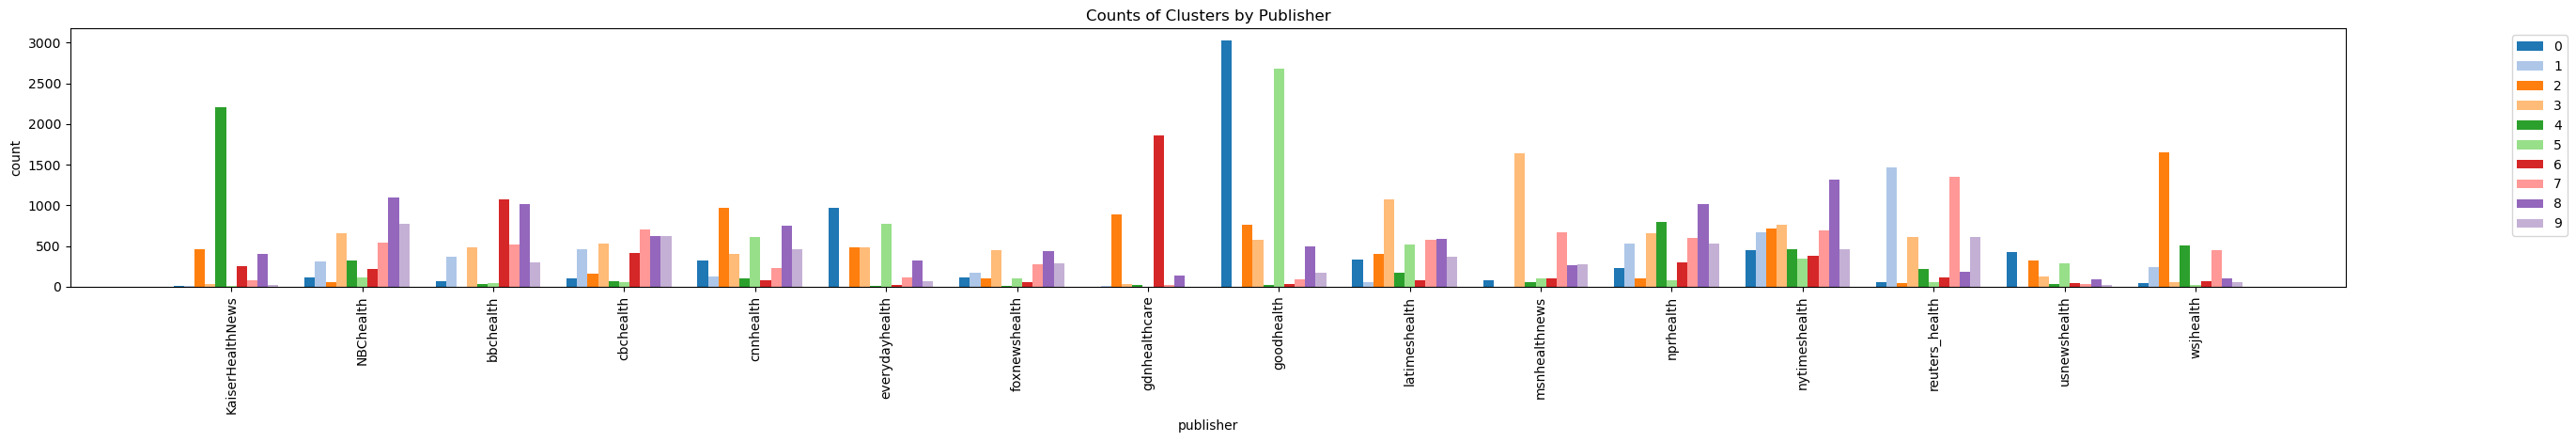

<Figure size 640x480 with 0 Axes>

In [13]:
# Example DataFrame
data = {
    'kmeans.bert.10': df['kmeans.bert.10'],
    'publisher': df['publisher'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['kmeans.bert.10', 'publisher'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:10])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        grouped_data.loc[group],
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('publisher')
ax.set_ylabel('count')
ax.set_title('Counts of Clusters by Publisher')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/cluster.by.pub.bert.2023-06-07.png')

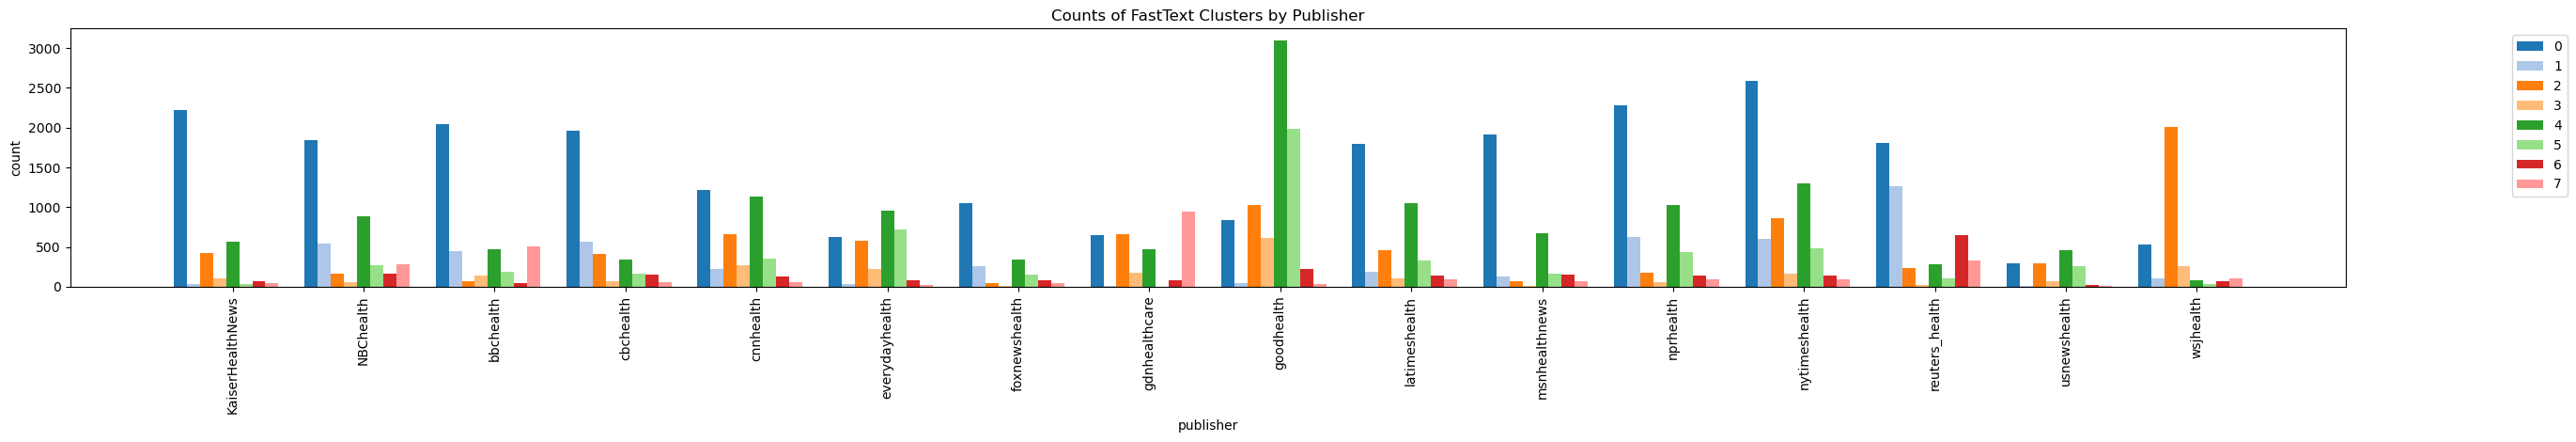

<Figure size 640x480 with 0 Axes>

In [15]:
# Example DataFrame
data = {
    'kmeans.fast.8': df['kmeans.fast.8'],
    'publisher': df['publisher'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['kmeans.fast.8','publisher'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:8])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        grouped_data.loc[group],
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('publisher')
ax.set_ylabel('count')
ax.set_title('Counts of FastText Clusters by Publisher')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/cluster.by.pub.fast.2023-06-07.png')

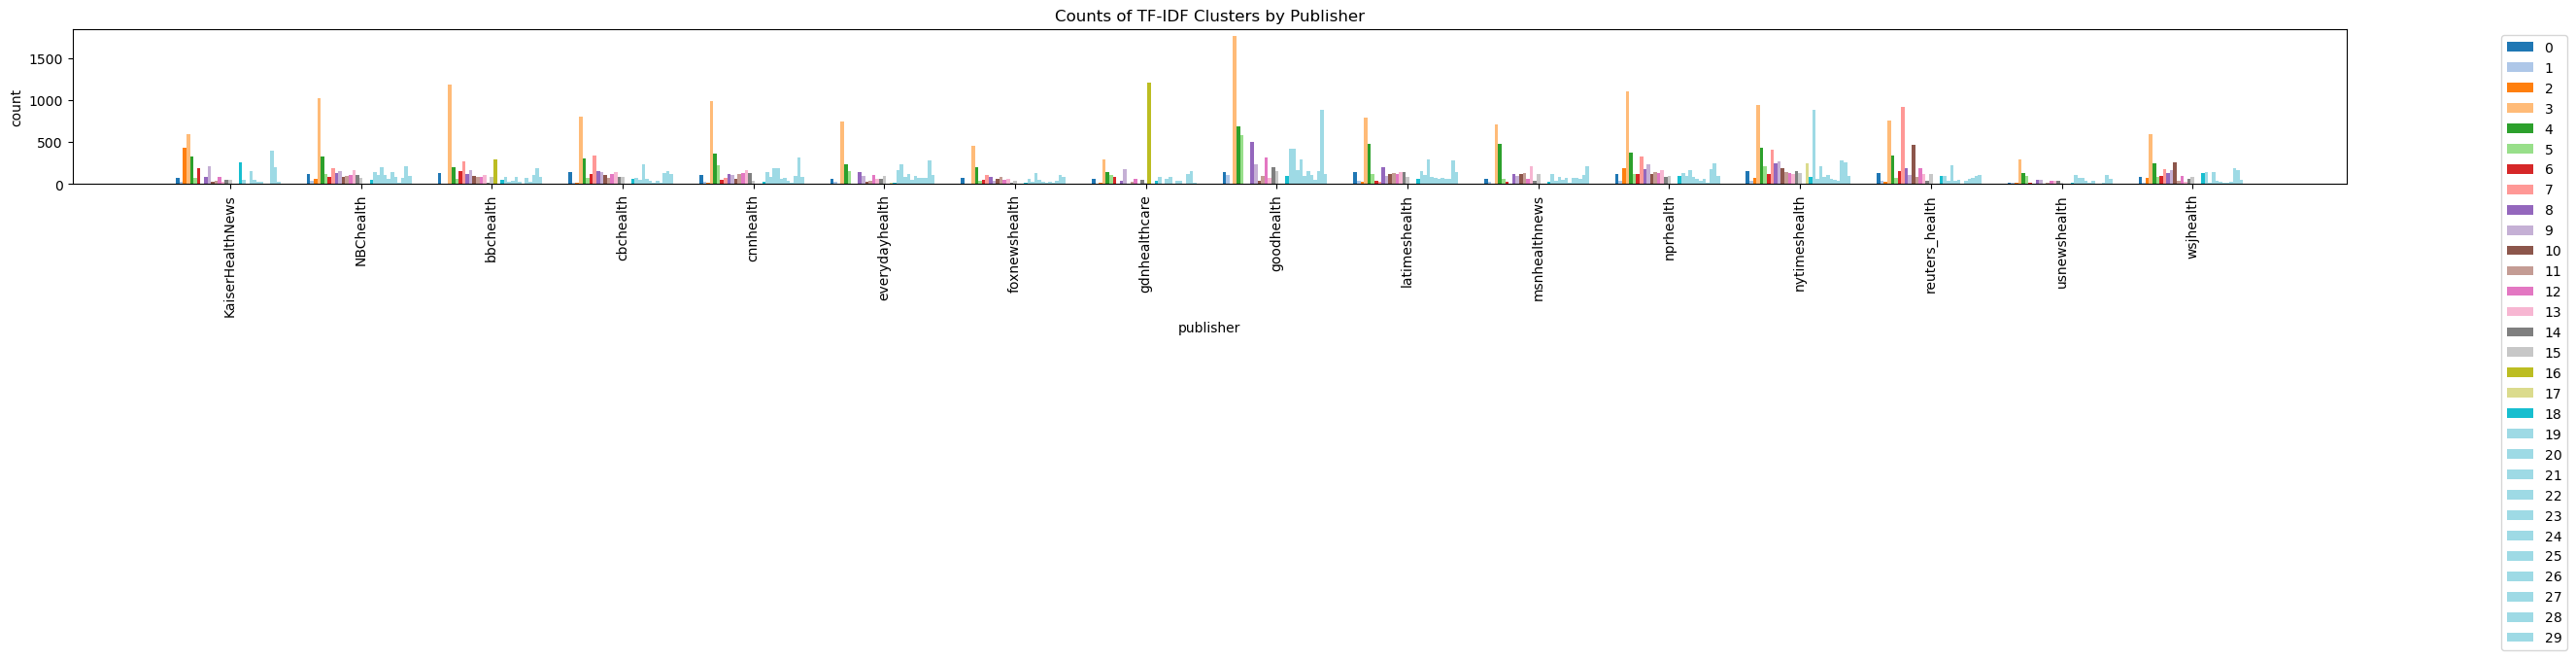

<Figure size 640x480 with 0 Axes>

In [16]:
data = {
    'kmeans.tfidf.30': df['kmeans.tfidf.30'],
    'publisher': df['publisher'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['kmeans.tfidf.30', 'publisher'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:30]) # i don't think there's enough colors

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        grouped_data.loc[group],
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('publisher')
ax.set_ylabel('count')
ax.set_title('Counts of TF-IDF Clusters by Publisher')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/cluster.by.pub.tfidf.2023-06-07.png')

Plots of Tweet Length by Cluster

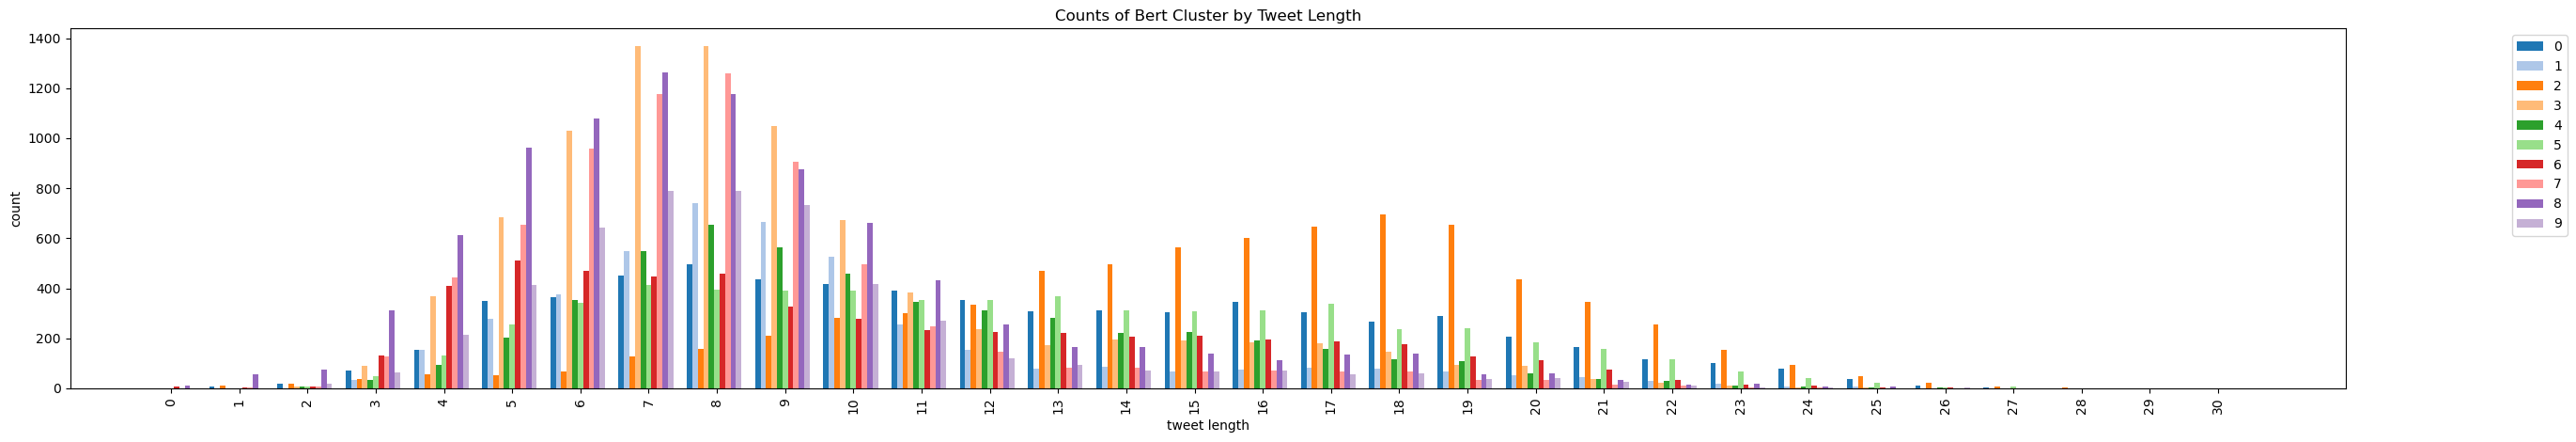

<Figure size 640x480 with 0 Axes>

In [18]:
# Example DataFrame
data = {
    'kmeans.bert.10': df['kmeans.bert.10'],
    'minClean.len': df['minClean.len'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['kmeans.bert.10', 'minClean.len'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:10])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        grouped_data.loc[group],
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('tweet length')
ax.set_ylabel('count')
ax.set_title('Counts of Bert Cluster by Tweet Length')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/cluster.by.len.bert.2023-06-07.png')

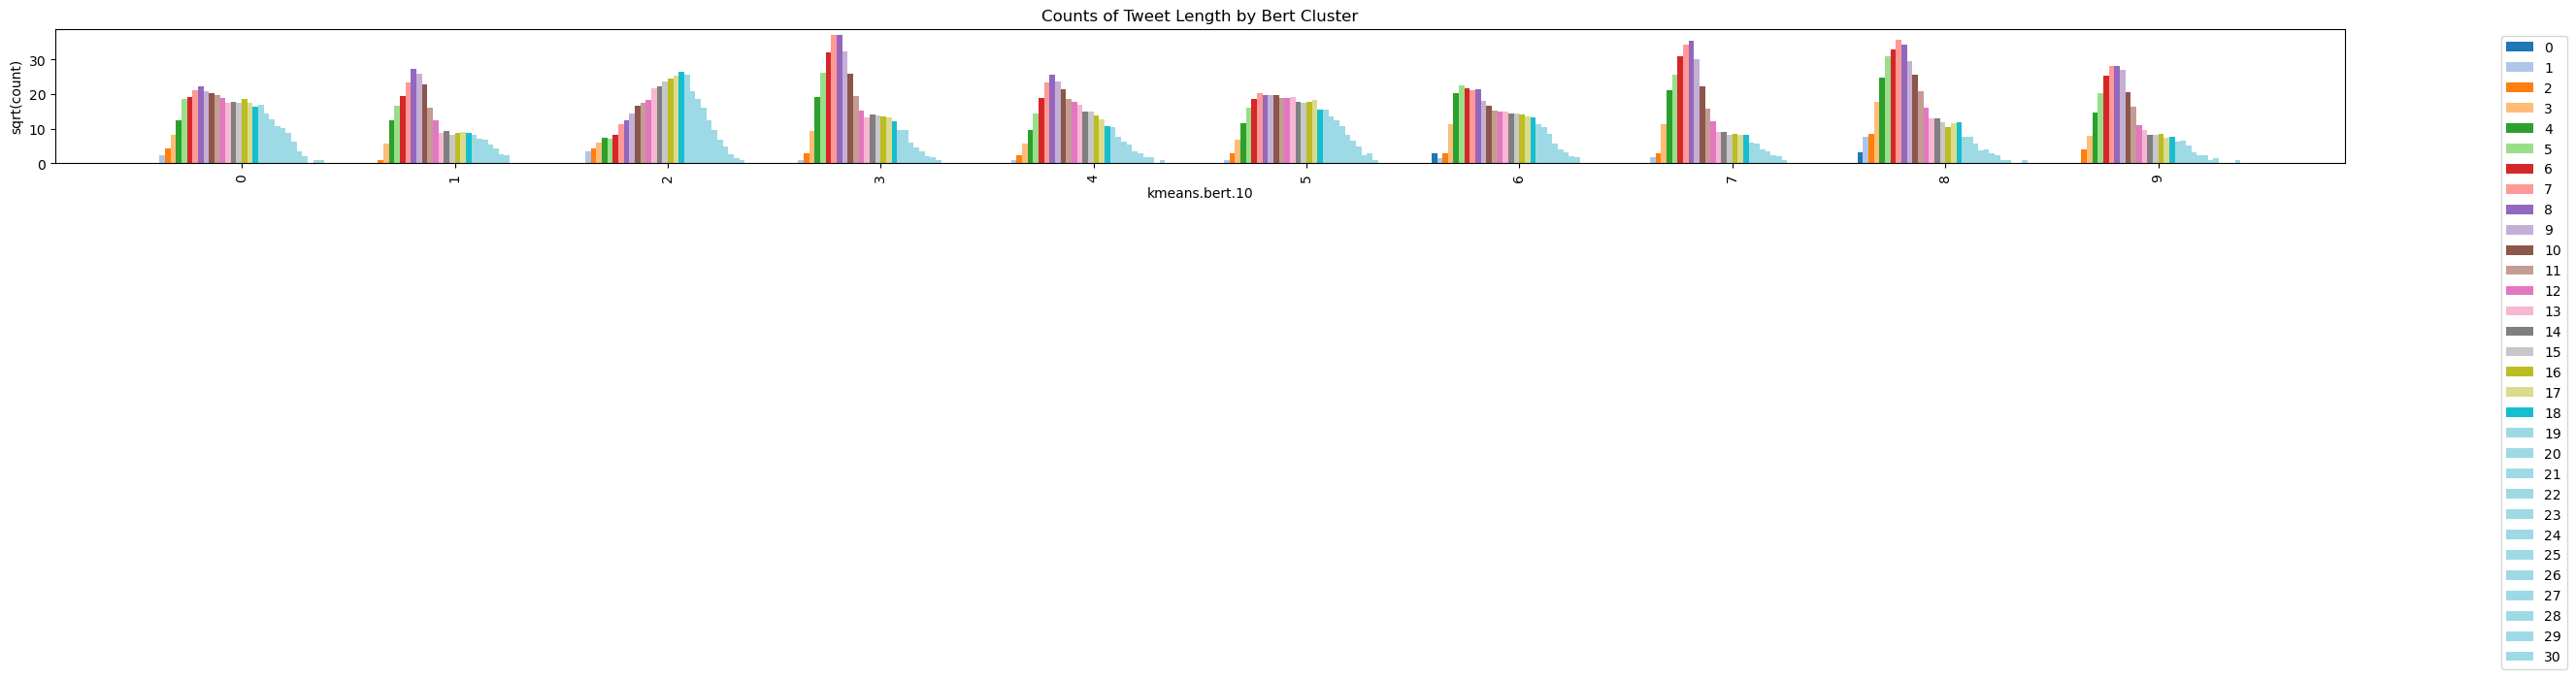

<Figure size 640x480 with 0 Axes>

In [19]:
# Example DataFrame
data = {
    'kmeans.bert.10': df['kmeans.bert.10'],
    'minClean.len': df['minClean.len'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['minClean.len', 'kmeans.bert.10'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:30])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        np.sqrt(grouped_data.loc[group]),
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('kmeans.bert.10')
ax.set_ylabel('sqrt(count)')
ax.set_title('Counts of Tweet Length by Bert Cluster')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/len.by.cluster.bert.2023-06-07.png')

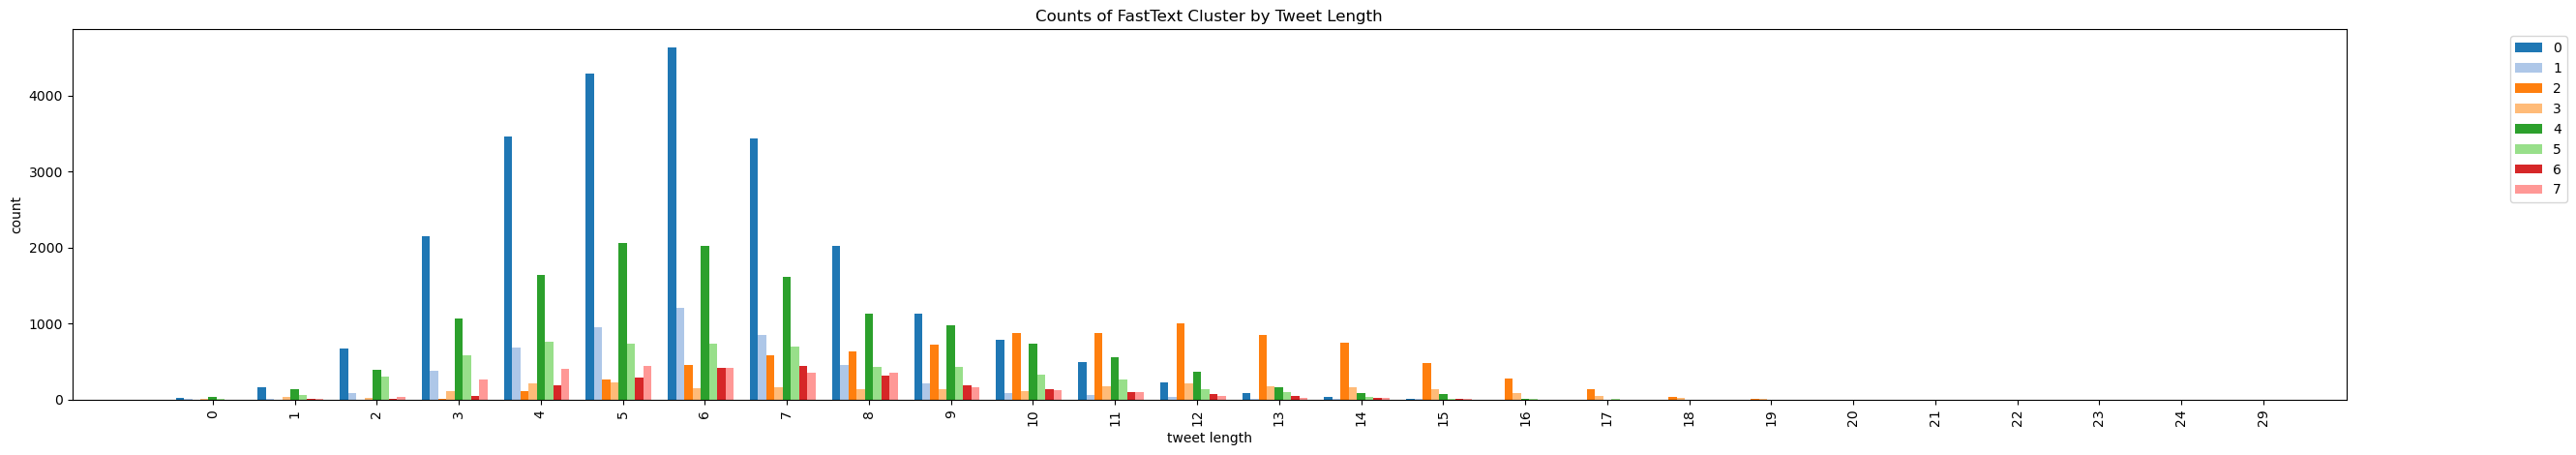

<Figure size 640x480 with 0 Axes>

In [20]:
# Example DataFrame
data = {
    'kmeans.fast.8': df['kmeans.fast.8'],
    'cleaned.len': df['cleaned.len'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['kmeans.fast.8', 'cleaned.len'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:10])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        grouped_data.loc[group],
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('tweet length')
ax.set_ylabel('count')
ax.set_title('Counts of FastText Cluster by Tweet Length')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/cluster.by.len.fast.2023-06-07.png')

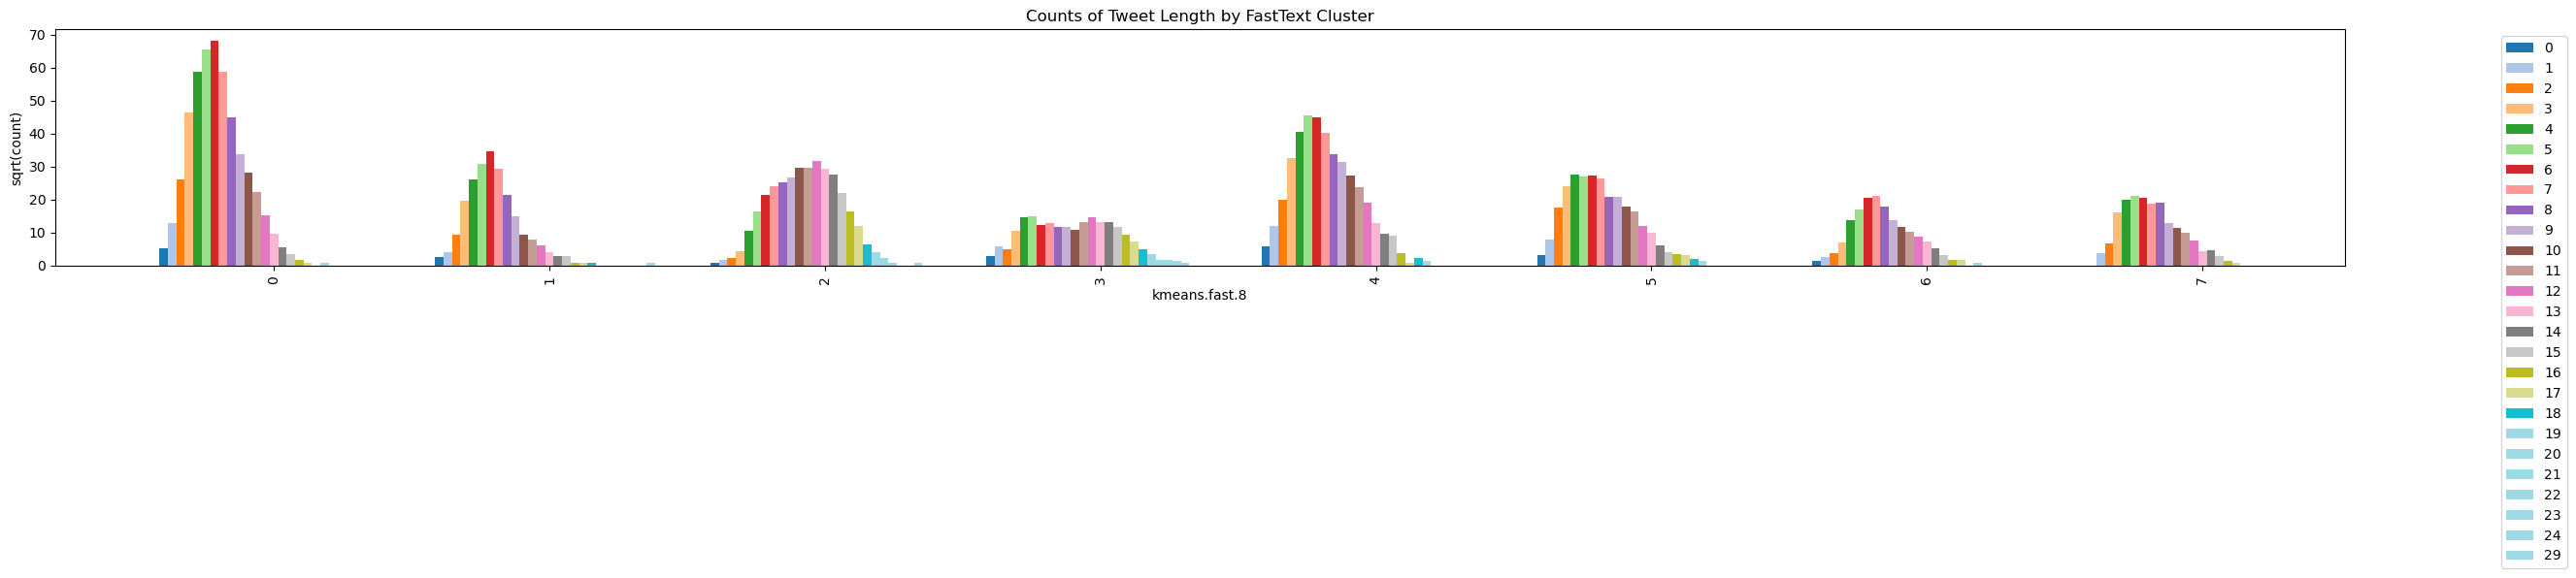

<Figure size 640x480 with 0 Axes>

In [21]:
# Example DataFrame
data = {
    'kmeans.fast.8': df['kmeans.fast.8'],
    'cleaned.len': df['cleaned.len'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['cleaned.len', 'kmeans.fast.8'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:30])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        np.sqrt(grouped_data.loc[group]),
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('kmeans.fast.8')
ax.set_ylabel('sqrt(count)')
ax.set_title('Counts of Tweet Length by FastText Cluster')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/len.by.cluster.fast.2023-06-07.png')

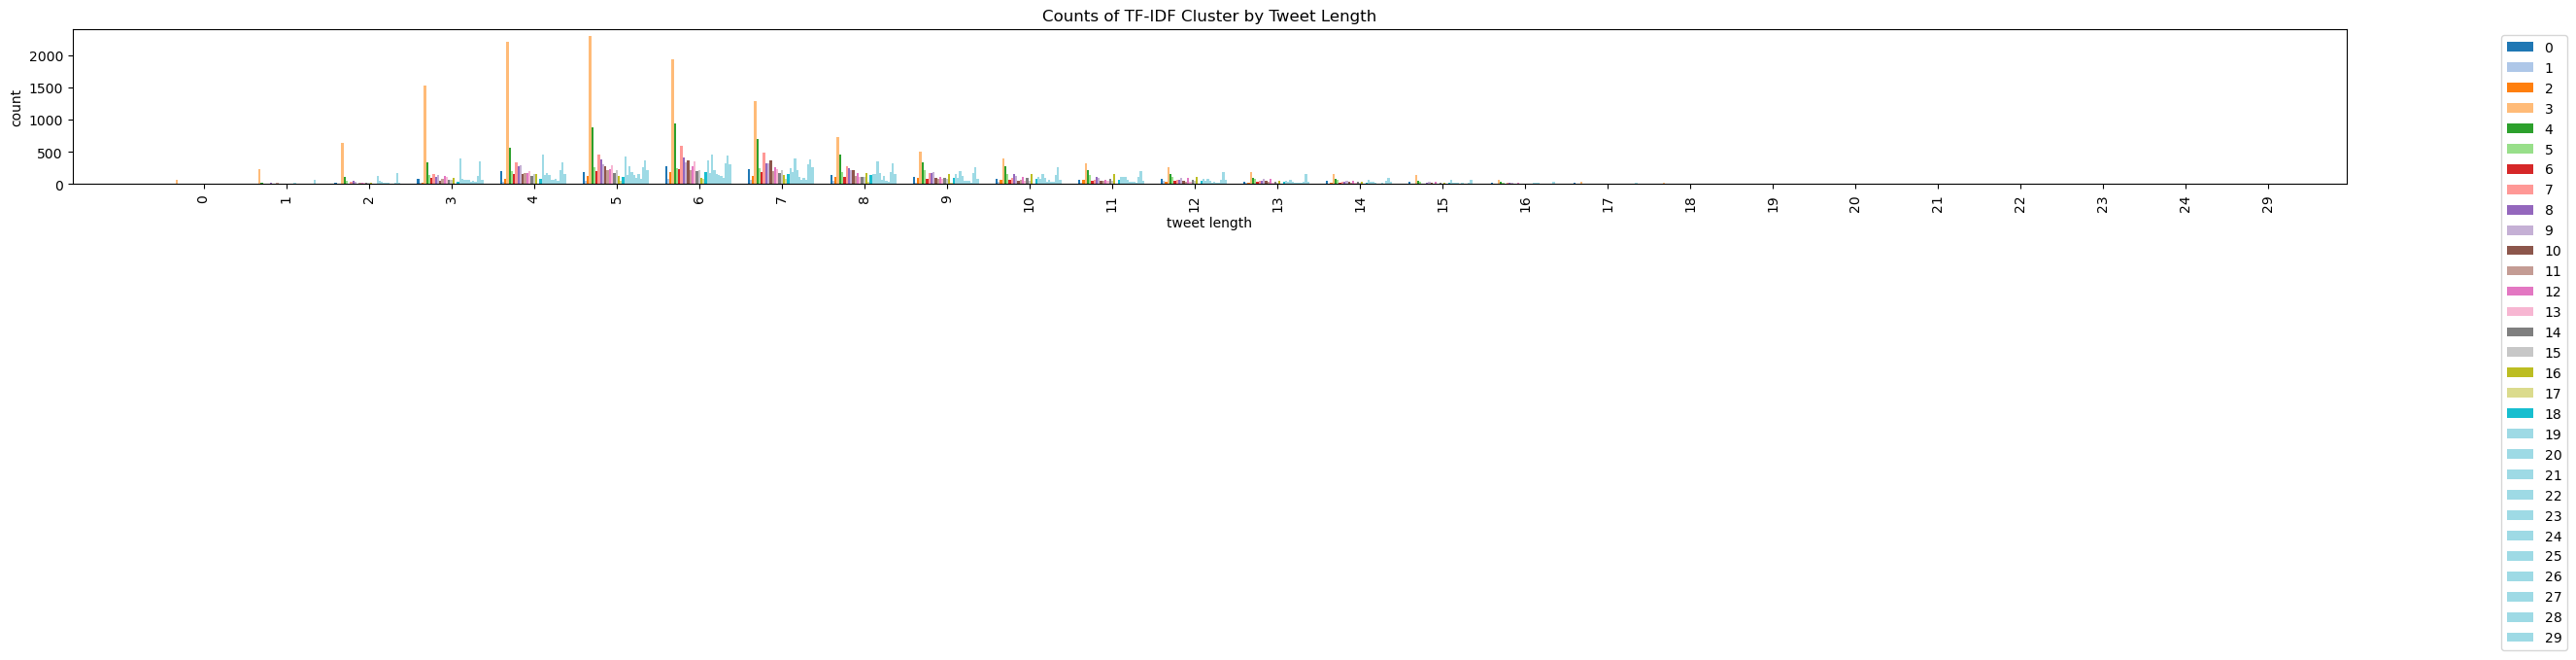

<Figure size 640x480 with 0 Axes>

In [22]:
# Example DataFrame
data = {
    'kmeans.tfidf.30': df['kmeans.tfidf.30'],
    'cleaned.len': df['cleaned.len'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['kmeans.tfidf.30', 'cleaned.len'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:30])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        grouped_data.loc[group],
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('tweet length')
ax.set_ylabel('count')
ax.set_title('Counts of TF-IDF Cluster by Tweet Length')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/cluster.by.len.tfidf.2023-06-07.png')

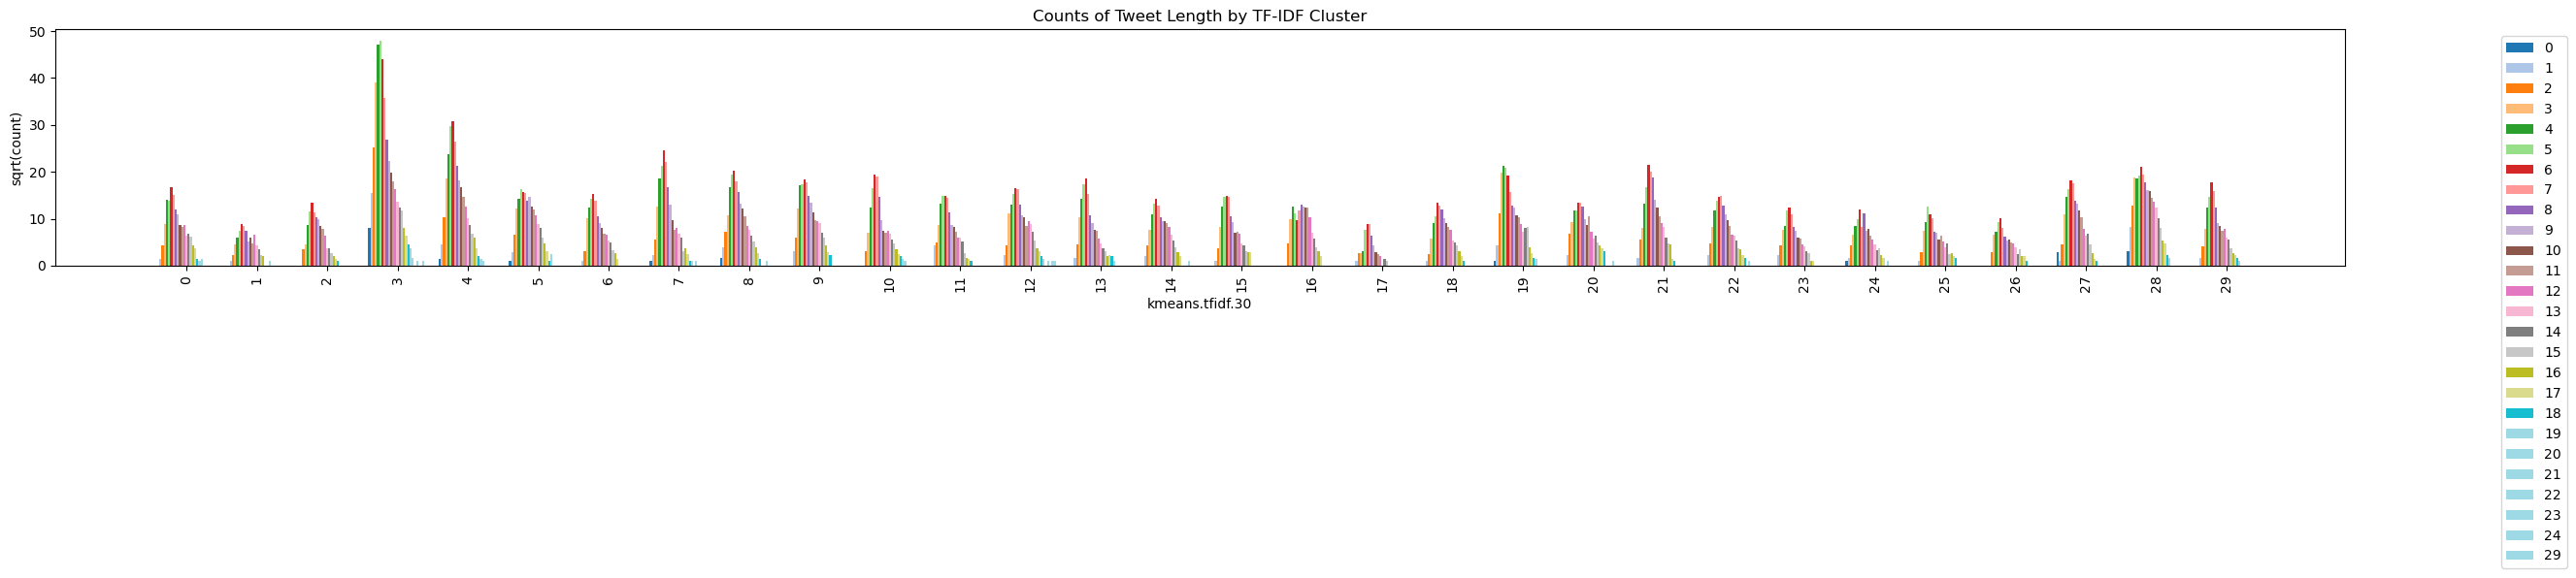

<Figure size 640x480 with 0 Axes>

In [23]:
# Example DataFrame
data = {
    'kmeans.tfidf.30': df['kmeans.tfidf.30'],
    'cleaned.len': df['cleaned.len'],
    'count': np.ones(df.shape[0])
}
plotFrame = pd.DataFrame(data)

# Group the data by 'Group' and 'Category' and calculate the counts for each combination
grouped_data = plotFrame.groupby(['cleaned.len', 'kmeans.tfidf.30'])['count'].sum().unstack()

# Define a colormap for the categories
colormap = mcolors.ListedColormap(plt.cm.tab20(np.linspace(0, 1, 20))[:30])

# Create the bar plot
fig, ax = plt.subplots()
width = 0.8 / len(grouped_data.index)

for i, group in enumerate(grouped_data.index):
    bars = ax.bar(
        np.arange(len(grouped_data.columns)) + i * width,
        np.sqrt(grouped_data.loc[group]),
        width,
        color=colormap(i)
    )

# Set the x-axis labels
ax.set_xticks(np.arange(len(grouped_data.columns)) + 0.4)
ax.set_xticklabels(grouped_data.columns, rotation = 90)

# Set the labels and title
ax.set_xlabel('kmeans.tfidf.30')
ax.set_ylabel('sqrt(count)')
ax.set_title('Counts of Tweet Length by TF-IDF Cluster')

# Add a legend
ax.legend(grouped_data.index, bbox_to_anchor=(1.1, 1))

# resize the plot
plt.tight_layout(rect=[0, 0, 4, 1])

# Display the plot
plt.show()
#plt.savefig('analysis.graphs/len.by.cluster.tfidf.2023-06-07.png')

Grouping by Datetime

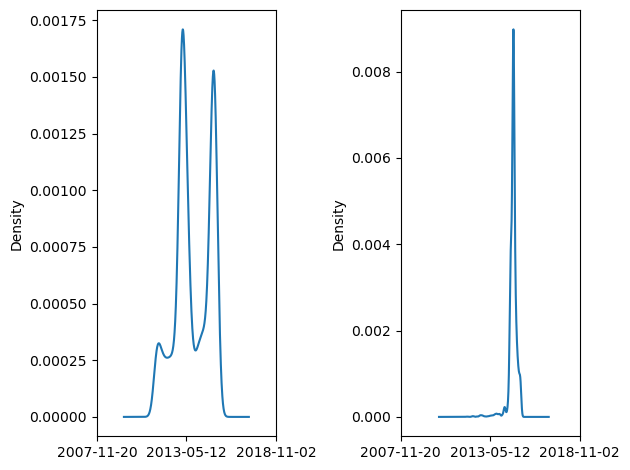

In [67]:
# fig, axes = plt.subplots(nrows=, ncols=5, figsize=(5, 3))

plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==0]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==1]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

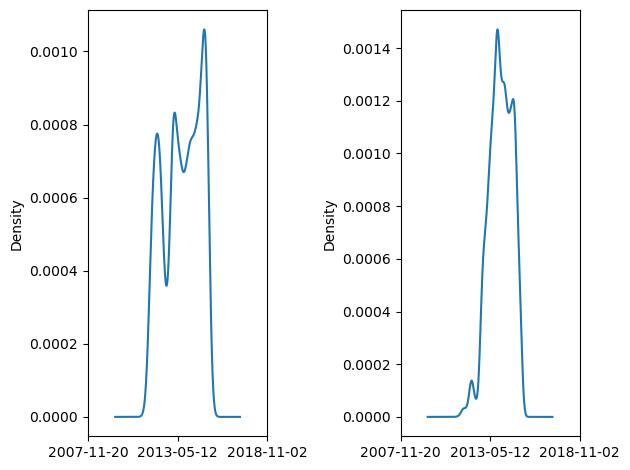

In [68]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==3]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==4]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

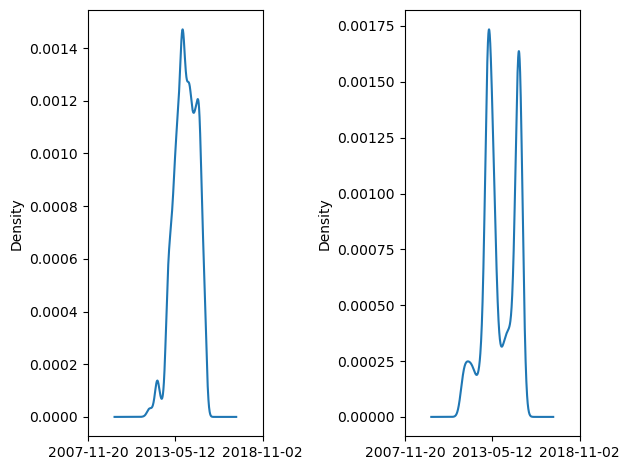

In [69]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==4]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==5]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

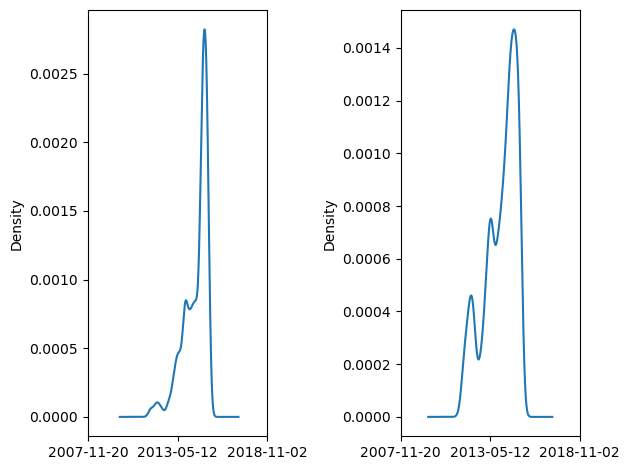

In [70]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==6]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==7]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

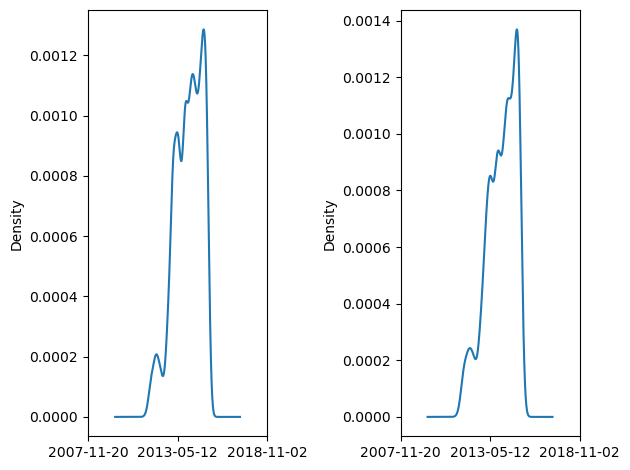

In [72]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==8]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.bert.10']==9]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

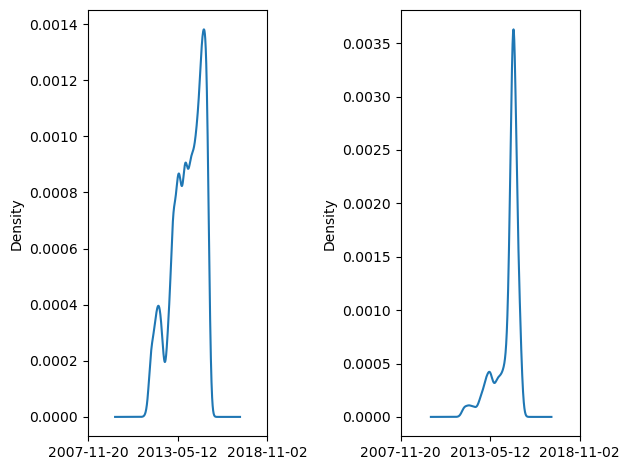

In [73]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.fast.8']==0]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.fast.8']==1]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

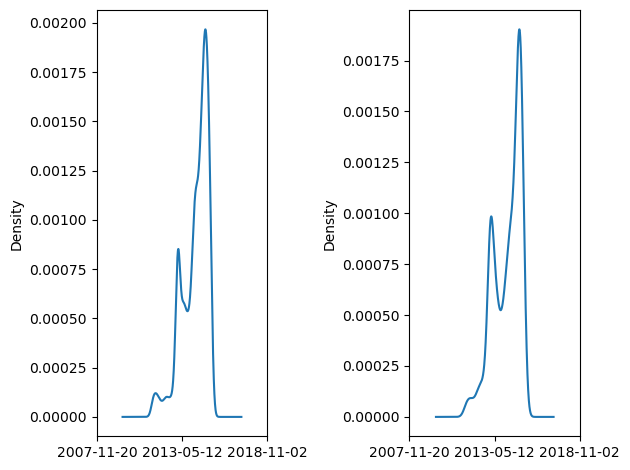

In [74]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.fast.8']==2]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.fast.8']==3]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

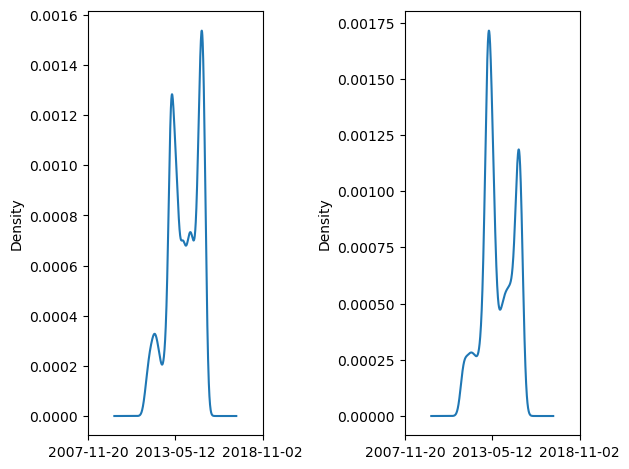

In [75]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.fast.8']==4]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.fast.8']==5]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

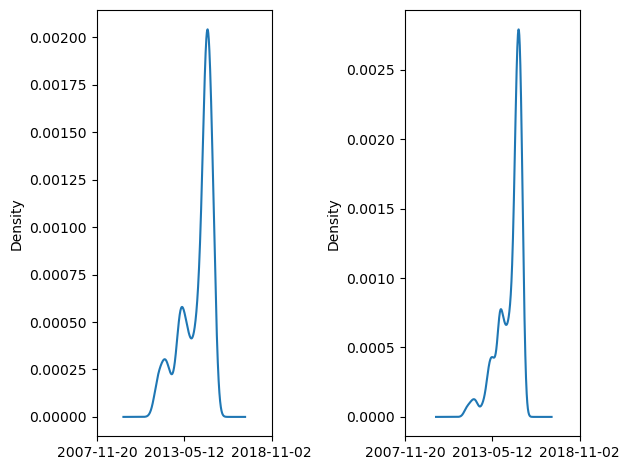

In [76]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.fast.8']==6]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.fast.8']==7]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

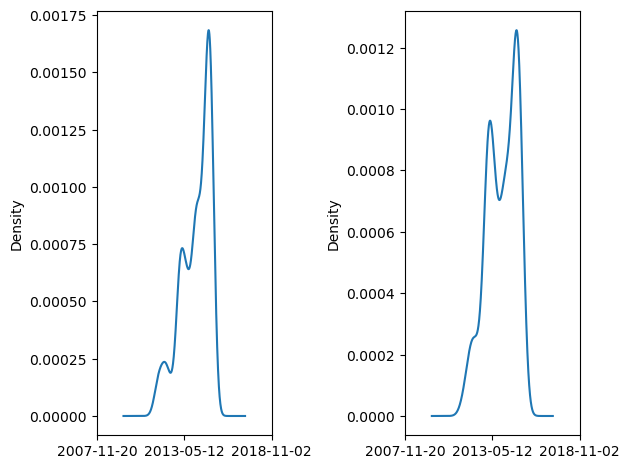

In [77]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==0]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==1]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

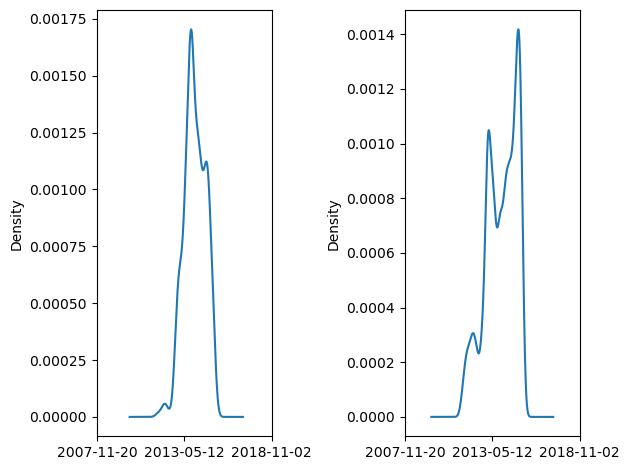

In [78]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==2]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==3]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

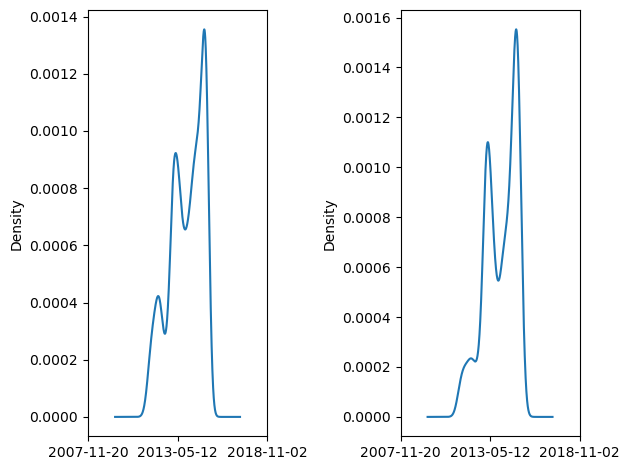

In [79]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==4]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==5]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

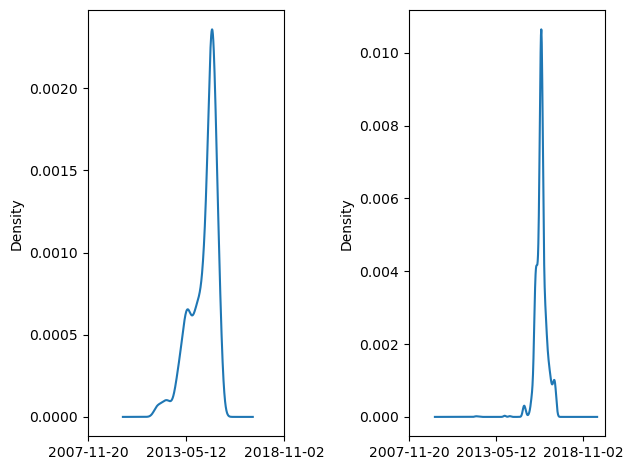

In [80]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==6]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==7]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

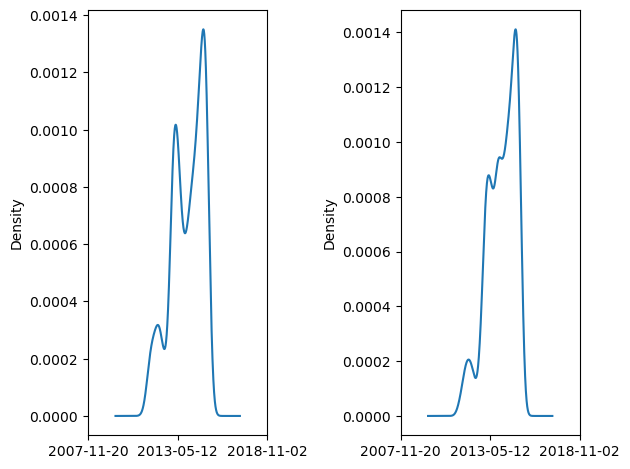

In [81]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==8]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==9]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

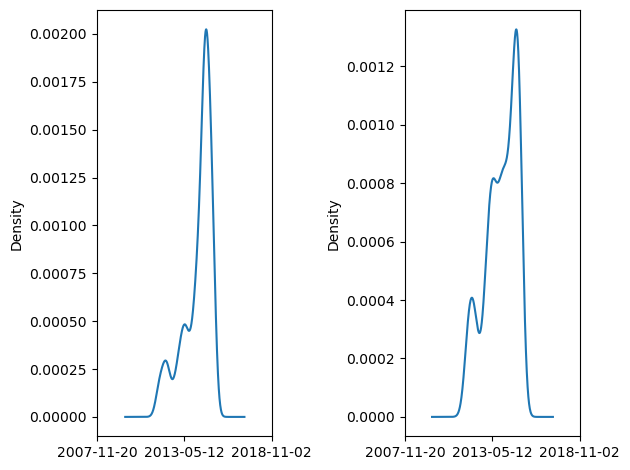

In [82]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==10]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==11]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

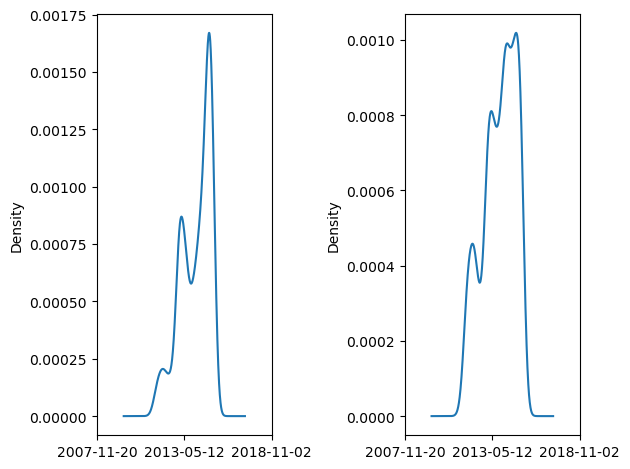

In [83]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==12]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==13]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

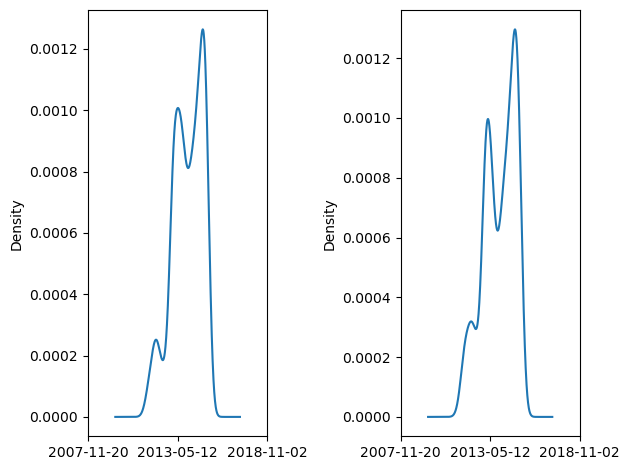

In [84]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==14]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==15]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

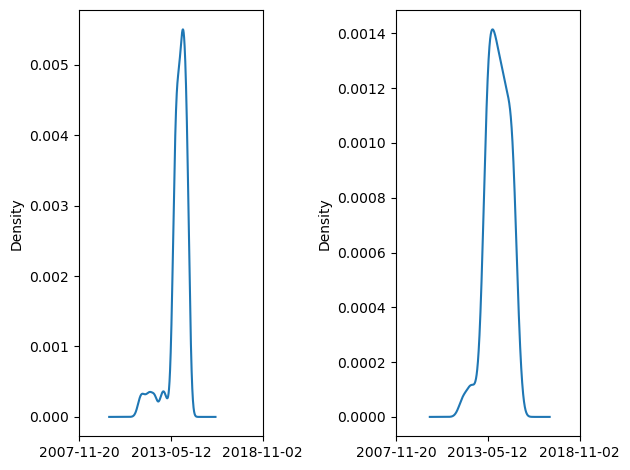

In [85]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==16]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==17]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

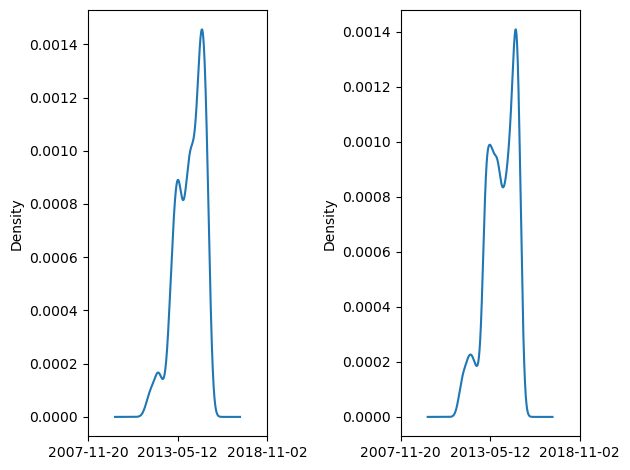

In [86]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==18]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==19]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

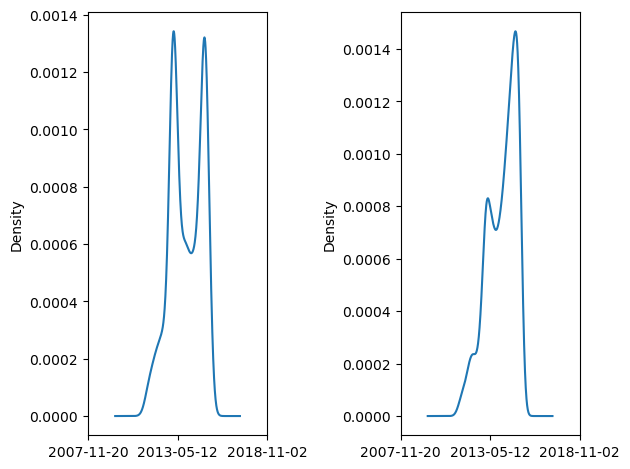

In [87]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==20]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==21]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

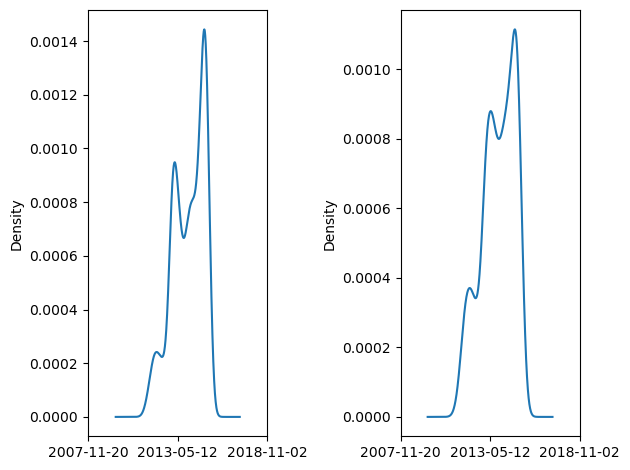

In [88]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==22]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==23]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

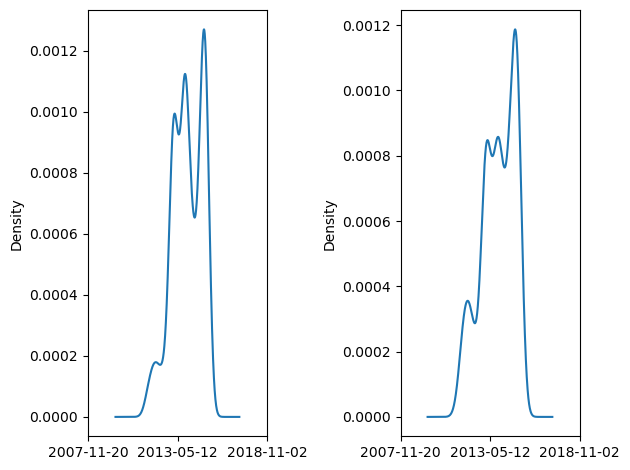

In [89]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==24]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==25]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

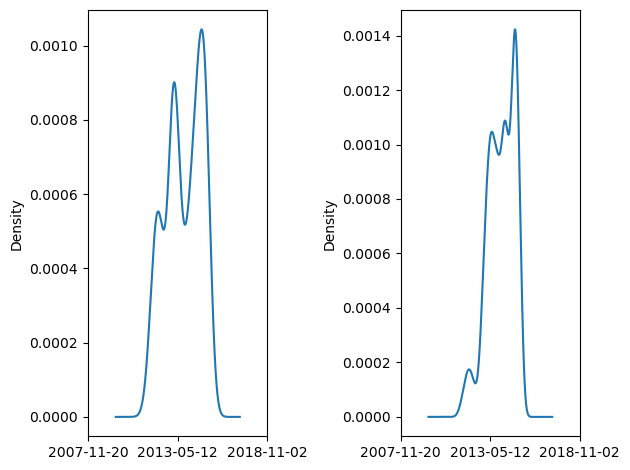

In [90]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==26]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==27]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()

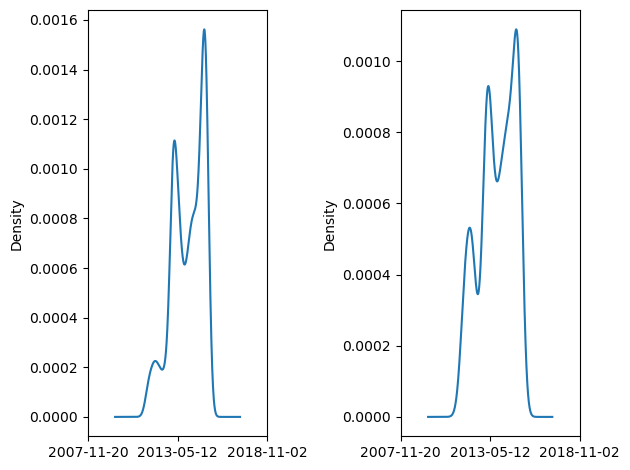

In [91]:
plt.subplot(1, 2, 1)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==28]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.subplot(1, 2, 2)
# plot non-parametric kde on numeric datenum
ax = df[df['kmeans.tfidf.30']==29]['ordinalTime'].plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
# xlabels = [pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

plt.tight_layout()